In [1]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit, gamma
from scipy.integrate import trapz, simpson
import scipy.interpolate as scint
import pandas as pd
import os
from importlib import reload

plt.style.use("../KD_style.mplstyle")

## Exercise 0

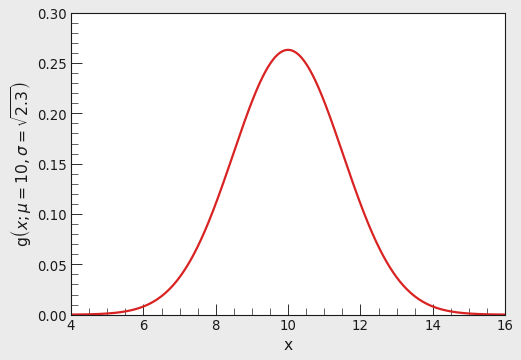

In [2]:
def gauss_pdf(x, mu, sigma):
    return stats.norm.pdf(x, mu, sigma)

mu_front = 10
sigma_front = np.sqrt(2.3)

x_front = np.arange(mu_front - 5 * sigma_front, mu_front + 5 * sigma_front, 0.01)
y_front = gauss_pdf(x_front, mu_front, sigma_front)
plt.plot(x_front, y_front)
xrange = (mu_front - 4 * sigma_front, mu_front + 4 * sigma_front)
plt.xlim(4, 16)
# plt.hlines(0, *xrange, color = "k", linewidth = 0.5)
plt.ylim(0, 0.3)
plt.grid(False)
plt.xlabel("x")
plt.ylabel(r"g$\left(x; \mu = 10, \sigma = \sqrt{2.3}\right)$")
plt.savefig("./gaussian.pdf", facecolor = "white")

## Exercise 1

In [3]:
def mc_ac_new(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    bool_mask = yran <= yfunc
    missing = N_points - np.sum(bool_mask)
    if missing > 0:
        xrest, yrest, bool_rest = mc_ac_new(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
        bool_rest = np.empty(0, dtype = bool)
    finalx = np.append(xran, xrest)
    finaly = np.append(yran, yrest)
    finalbool = np.append(bool_mask, bool_rest)
    return finalx, finaly, finalbool

def mc_ac_df(func, xmin, xmax, ymin, ymax, N_points, upside_down = False, **kwargs):
    x, y, mask = mc_ac_new(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    if upside_down:
        mask = np.invert(mask)
    df = pd.DataFrame({"x": x, "y": y, "accept": mask})
    tries = len(x)
    eff = np.sum(mask)/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return df, {"area": area, "effeciency": eff, "tries": tries}

def acceptreject_faster(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran <= yfunc]
    ykeep = yran[yran <= yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest = acceptreject_faster(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    return finalx, finaly

def acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    # Recursive function to do accept/reject monte carlo simulation
    xran = np.random.uniform(xmin, xmax, N_points)
    yran = np.random.uniform(ymin, ymax, N_points)
    yfunc = func(xran, **kwargs)
    xkeep = xran[yran <= yfunc]
    ykeep = yran[yran <= yfunc]
    missing = N_points - len(xkeep)
    if missing > 0:
        xrest, yrest, all_xrest, all_yrest, tries = acceptreject(func, xmin, xmax, ymin, ymax, missing, **kwargs)
    else:
        xrest = np.empty(0)
        yrest = np.empty(0)
        all_xrest = np.empty(0)
        all_yrest = np.empty(0)
        tries = 0
    finalx = np.append(xkeep, xrest)
    finaly = np.append(ykeep, yrest)
    allx = np.append(xran, all_xrest)
    ally = np.append(yran, all_yrest)
    finaltries = N_points + tries
    return finalx, finaly, allx, ally, finaltries

def acceptrejectdata(func, xmin, xmax, ymin, ymax, N_points, **kwargs):
    x, y, all_x, all_y, tries = acceptreject(func, xmin, xmax, ymin, ymax, N_points, **kwargs)
    eff = N_points/tries
    area = (xmax - xmin) * (ymax - ymin) * eff
    return x, y, all_x, all_y, (area, eff, tries)

def num_int2(func, xmin, xmax, points = 1000000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    y = func(x, **kwargs)
    y_ave = y[1:] + (y[1:] - y[:-1])/2
    width = (xmax-xmin)/(points-1)
    area = np.sum(y_ave)*width
    return area

In [4]:
alpha = 0.9
beta = 0.55

xmin = -1.02
xmax = 1.11

def poly_pdf1(x, a, b):
    xmin = -1.02
    xmax = 1.11
    return (1+a*x+b*x**2)/((b*(-xmin**3+xmax**3)/3)+(a*(-xmin**2+xmax**2)/2)+(xmax-xmin))

xmin = -1.02
xmax = 1.11
ymin = 0
ymax = poly_pdf1(xmax, alpha, beta)

N_accept = 807

xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)

poly_df, poly_info = mc_ac_df(poly_pdf1, xmin, xmax, ymin, ymax, N_accept, a = alpha, b = beta)
print(poly_info)
display(poly_df)
display(poly_df[["x", "y"]].loc[poly_df["accept"]])
# print(poly_df["x"])

{'area': 1.0132848020741807, 'effeciency': 0.4730363423212192, 'tries': 1706}


,x,y,accept
0,-0.297594,0.994968,False
1,0.443276,0.023455,True
2,0.981466,0.725749,True
3,0.287439,0.353751,True
4,0.970361,0.420599,True
...,...,...,...
1701,-0.209679,0.289273,True
1702,-0.546629,0.168712,True
1703,0.667470,0.833532,False
1704,0.553747,0.028494,True


,x,y
1,0.443276,0.023455
2,0.981466,0.725749
3,0.287439,0.353751
4,0.970361,0.420599
5,-1.012720,0.192049
...,...,...
1695,-0.337247,0.127323
1701,-0.209679,0.289273
1702,-0.546629,0.168712
1704,0.553747,0.028494


(0.0, 1.1)

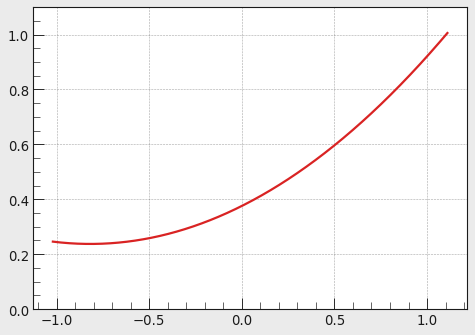

In [5]:
def num_int1(func, xmin, xmax, points = 100000, **kwargs):
    x = np.linspace(xmin, xmax, points)
    area = np.sum(func(x, **kwargs))/points*(xmax-xmin)
    return area

alpha = 0.9
beta = 0.55

xmin = -1.02
xmax = 1.11

def poly_pdf1(x, a, b):
    xmin = -1.02
    xmax = 1.11
    return (1+a*x+b*x**2)/((b*(-xmin**3+xmax**3)/3)+(a*(-xmin**2+xmax**2)/2)+(xmax-xmin))

xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)
plt.plot(xquick, yquick)
plt.ylim(0,1.1)


(0.9727990277650829, 0.45413618458075405, 1777)


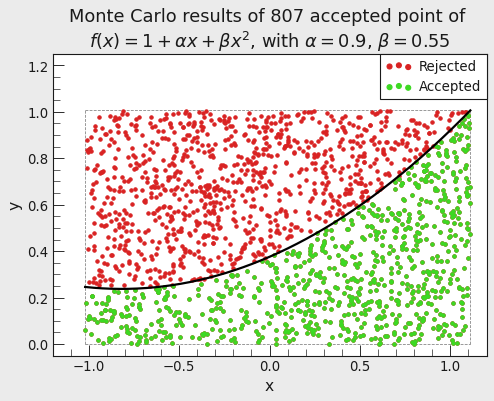

In [6]:
xmin = -1.02
xmax = 1.11
ymin = 0
ymax = poly_pdf1(xmax, alpha, beta)

N_accept = 807


xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)
x, y, allx, ally, poly_MC_info = acceptrejectdata(poly_pdf1, xmin, xmax, ymin, ymax, N_accept, a = alpha, b = beta)

print(poly_MC_info)
plt.plot(xquick, yquick, color = "k")
plt.scatter(allx, ally, label = "Rejected")
plt.scatter(x,y, color = "#3dd923", label = "Accepted")
plt.grid(False)
plt.hlines(ymin, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.hlines(ymax, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmin, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmax, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.ylim(-0.05, 1.25)
plt.xlim(-1.2, 1.2)
plt.legend(scatterpoints = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 807 accepted point of \n" + r"$f(x) = 1 + \alpha x + \beta x^{2}$, with $\alpha = 0.9$, $\beta = 0.55$")
# plt.savefig("./montecarlo_poly_1.pdf", facecolor = "white")
plt.show()

# pd.DataFrame(np.array([x, y]).T, columns = ["x", "y"]).to_csv("./Kofoeddjursner_polynomial.txt" , index = None)

0.9999999992086818
0.20458816554858644
(0.9910644846687898, 0.24220963172804533, 2118)


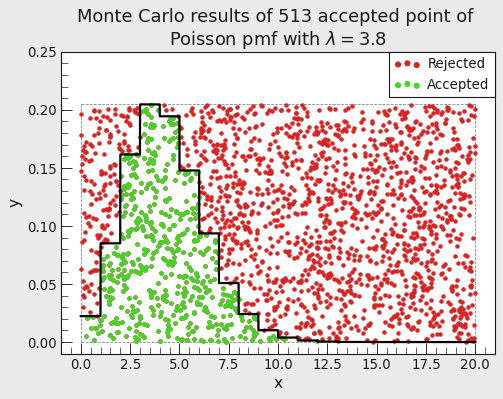

In [7]:
def poisson_pmf(x, lamb):
    return stats.poisson.pmf(np.floor(x), lamb)

xmin = 0
xmax = 20

lamb = 3.8
print(stats.poisson.cdf(xmax, lamb))
ymin = 0
ymax = poisson_pmf(lamb, lamb)
print(ymax)
N_accept = 513

xquick = np.linspace(xmin, xmax, 10000)
yquick = poisson_pmf(xquick, lamb)

x, y, allx, ally, poi_MC_info = acceptrejectdata(poisson_pmf, xmin, xmax, ymin, ymax, N_accept, lamb = lamb)
print(poi_MC_info)
plt.plot(xquick, yquick, color = "k")
plt.scatter(allx, ally, label = "Rejected")
plt.scatter(x,y, color = "#3dd923", label = "Accepted")
plt.grid(False)
plt.hlines(ymin, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.hlines(ymax, xmin, xmax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmin, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.vlines(xmax, ymin, ymax, color = "k", alpha = 0.5, zorder = -10, linestyle = "dashed", linewidth = 0.7)
plt.ylim(-0.01, 0.25)
# plt.xlim(-1.2, 1.2)
plt.legend(scatterpoints = 3)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 513 accepted point of \n" + r"Poisson pmf with $\lambda = 3.8$")
# plt.savefig("./montecarlo_poisson_1.pdf", facecolor = "white")
plt.show()

# pd.DataFrame(np.array([x, y]).T, columns = ["x", "y"]).to_csv("./Kofoeddjursner_poisson.txt" , index = None)

In [8]:
sys.path.append('../Extra_External_Functions')
import EEF
reload(EEF)
from EEF import Datahandler

C:\Users\phili\AppData\Local\Temp/ipykernel_28652/1290560385.py:45: RuntimeWarning: invalid value encountered in sqrt
  poly_x_err = np.sqrt(poly_x)


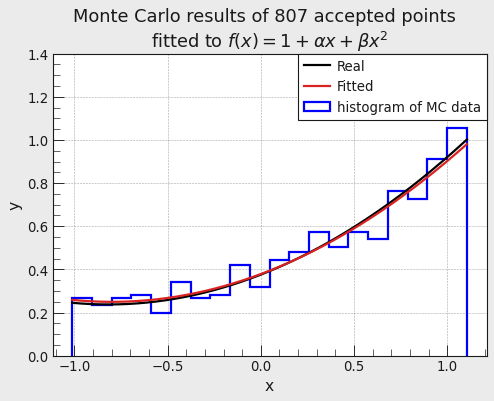

[0.85167108 0.5324863 ] [0.08340617 0.14908379]


In [9]:
poly_x, poly_y = pd.read_csv("./Kofoeddjursner_polynomial.txt").values.T

def ullhfit(x, fitfunc, **kwargs):

    def obt(*args):
        logf = np.zeros_like(x)
        
        # compute the function value
        f = fitfunc(x, *args)
    
        # find where the PDF is 0 or negative (unphysical)        
        mask_f_positive = f > 0

        # calculate the log of f everyhere where f is positive
        logf[mask_f_positive] = np.log(f[mask_f_positive])
        # set everywhere else to badvalue
        logf[~mask_f_positive] = -1000000
        
        # compute the sum of the log values: the LLH
        llh = -np.sum(logf)
        return llh

    ullh_Min = Minuit(obt, **kwargs, name = [*kwargs])
    ullh_Min.errordef = 0.5
    ullh_Min.migrad()
    valuesfit = np.array(ullh_Min.values, dtype = np.float64)
    errorsfit = np.array(ullh_Min.errors, dtype = np.float64)
    if not ullh_Min.valid:
        print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")
    # *** Impliment p-value for ullh fit
    
    return valuesfit, errorsfit

poly_fit, poly_errors = ullhfit(poly_x, poly_pdf1, a = alpha, b = beta)
xmin = np.min(poly_x)
xmax = np.max(poly_x)
xquick = np.linspace(xmin, xmax, 10000)
yquick = poly_pdf1(xquick, alpha, beta)
# x, y, allx, ally, poly_MC_info = acceptrejectdata(poly_pdf1, xmin, xmax, ymin, ymax, N_accept, a = alpha, b = beta)

# print(poly_MC_info)
plt.plot(xquick, yquick, color = "k", label = "Real")
# plt.scatter(allx, ally, label = "Rejected")
# plt.scatter(poly_x, poly_y, color = "#3dd923", label = "Accepted")
poly_x_err = np.sqrt(poly_x)
plt.hist(poly_x, bins = 20, density=True, color = "b", histtype="step", linewidth = 2, label = "histogram of MC data")
plt.plot(xquick, poly_pdf1(xquick, *poly_fit), label = "Fitted")
plt.ylim(0, 1.4) 
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 807 accepted points  \n" + r"fitted to $f(x) = 1 + \alpha x + \beta x^{2}$")
plt.savefig("./fit_poly_1.pdf", facecolor = "white")
plt.show()
print(poly_fit, poly_errors)

[3.89286919] [0.08711255]


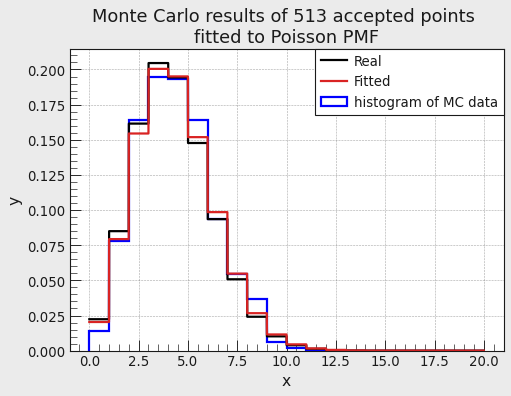

In [75]:
poi_x, poi_y = pd.read_csv("./Kofoeddjursner_poisson.txt").values.T

poi_fit, poi_errors = ullhfit(poi_x, poisson_pmf, lamb = 4)
xmin = np.min(poi_x)
xmax = np.max(poi_x)
xquick = np.linspace(0, 20, 10000)
yquick = poisson_pmf(xquick, lamb = lamb)
plt.plot(xquick, yquick, color = "k", label = "Real")
# plt.scatter(poi_x, poi_y, color = "#3dd923", label = "Accepted")
plt.hist(poi_x, bins = 20, range = (0,20), density=True, color = "b", histtype="step", linewidth = 2, label = "histogram of MC data")
plt.plot(xquick, poisson_pmf(xquick, *poi_fit), label = "Fitted")
print(poi_fit, poi_errors)

plt.xlabel("x")
plt.ylabel("y")
plt.title("Monte Carlo results of 513 accepted points \n" + r"fitted to Poisson PMF")
plt.legend()
plt.savefig("./fit_poi_1.pdf", facecolor = "white")

## Problem 2

In [11]:
spline = pd.read_csv("./OutlineAreaSpline.txt", sep = " ", skiprows=1, names= ["x", "y"])
# display(spline)
lower = pd.concat([spline[:12],spline[37:]]).sort_values("x")
upper = spline[12:37].sort_values("x")

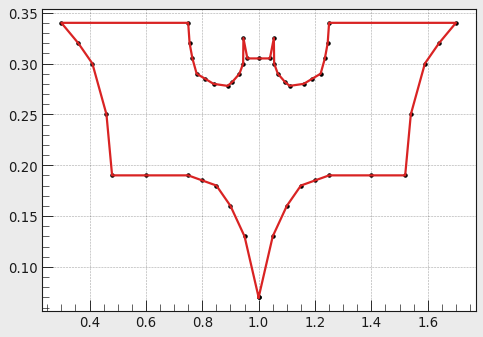

In [12]:
plt.scatter(spline["x"], spline["y"], color = "k")
plt.plot(spline["x"], spline["y"])

Text(0, 0.5, 'y')

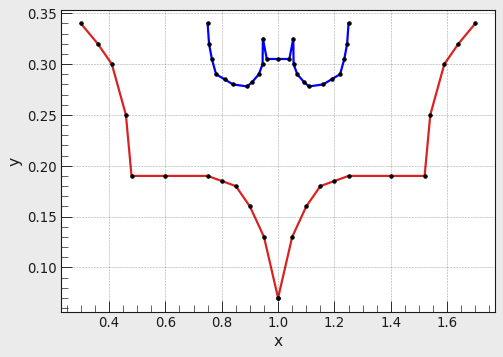

In [13]:
plt.plot(lower["x"], lower["y"], zorder = -10)
plt.scatter(lower["x"], lower["y"], color = "k")
plt.plot(upper["x"], upper["y"], color = "b", zorder = -10)
plt.scatter(upper["x"], upper["y"], color = "k")
plt.xlabel("x")
plt.ylabel("y")
# plt.savefig("./spline_look.pdf", facecolor = "White")

In [14]:
lower_int_spline = scint.interp1d(lower["x"].values, lower["y"].values, kind = "linear")
upper_int_spline = scint.interp1d(upper["x"].values, upper["y"].values, kind = "linear")

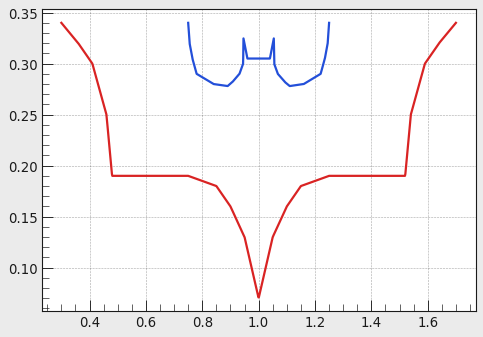

In [15]:
x_line_lower = np.linspace(np.min(lower["x"]), np.max(lower["x"]), 1000)
x_line_upper = np.linspace(np.min(upper["x"]), np.max(upper["x"]), 1000)
plt.plot(x_line_lower, lower_int_spline(x_line_lower))
plt.plot(x_line_upper, upper_int_spline(x_line_upper))

In [16]:
xmin = np.min(lower["x"])
xmax = np.max(lower["x"])
ymin = np.min(lower["y"])
ymax = np.max(lower["y"])
lower_ar, lower_info = mc_ac_df(lower_int_spline, xmin, xmax, ymin, ymax, 100000, upside_down=True)
print(lower_info)
# sns.scatterplot(x = "x", y = "y", data = lower_ar, hue="accept")

{'area': 0.18791748004887834, 'effeciency': 0.4971361906054983, 'tries': 198861}


{'area': 0.02402508718641017, 'effeciency': 0.7750028124648441, 'tries': 44445}


(0.05, 0.45)

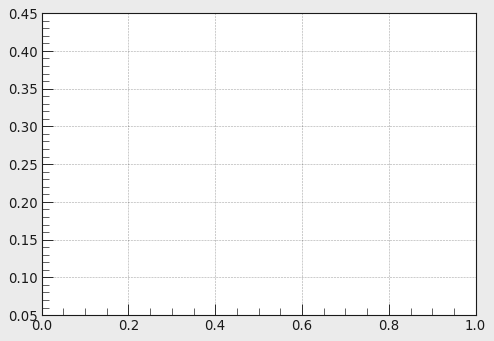

In [17]:
xmin = np.min(upper["x"])
xmax = np.max(upper["x"])
ymin = np.min(upper["y"])
ymax = np.max(upper["y"])
upper_ar, upper_info = mc_ac_df(upper_int_spline, xmin, xmax, ymin, ymax, 10000, upside_down=True)
print(upper_info)
# sns.scatterplot(x = "x", y = "y", data = upper_ar, hue="accept")
plt.ylim(0.05, 0.45)

0.004307124910638049


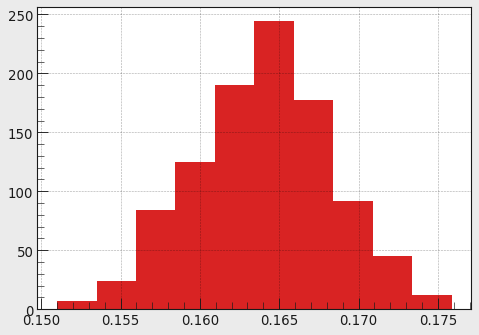

In [29]:
runs = 1000
runs_list = np.zeros(runs)
for idx in range(runs):
    xmin = np.min(lower["x"])
    xmax = np.max(lower["x"])
    ymin = np.min(lower["y"])
    ymax = np.max(lower["y"])
    lower_ar, lower_info = mc_ac_df(lower_int_spline, xmin, xmax, ymin, ymax, 1000, upside_down=True)

    xmin = np.min(upper["x"])
    xmax = np.max(upper["x"])
    ymin = np.min(upper["y"])
    ymax = np.max(upper["y"])
    upper_ar, upper_info = mc_ac_df(upper_int_spline, xmin, xmax, ymin, ymax, 1000, upside_down=True)

    total_area = lower_info["area"]- upper_info["area"]
    runs_list[idx] = total_area
    
plt.hist(runs_list)
print(np.std(runs_list, ddof = 1))

In [18]:
total_area = lower_info["area"]- upper_info["area"]
print(total_area) # area  = 0.1636 before redone code for plotting After 0.1632 with more points ()

0.16389239286246818


In [19]:
upper_ar["accept"] = np.invert(upper_ar["accept"].values)

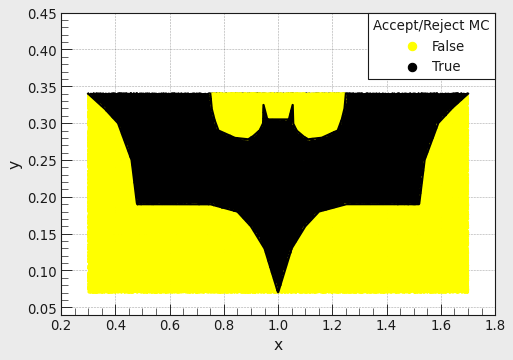

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(x = "x", y = "y", data = lower_ar, hue="accept", legend=False, palette=["yellow", "black"], linewidth = 0, s = 20, ax = ax)
sns.scatterplot(x = "x", y = "y", data = upper_ar, hue="accept", palette=["yellow", "black"], linewidth = 0, s = 20, ax = ax)
ax.plot(x_line_lower, lower_int_spline(x_line_lower), color = "k")
ax.plot(x_line_upper, upper_int_spline(x_line_upper), color = "k")
ax.set_ylim(0.04, 0.45)
ax.set_xlim(0.2, 1.8)
ax.set_axisbelow(True)
ax.legend(scatterpoints = 1, markerscale = 2.5, title = "Accept/Reject MC", title_fontsize = 12)
plt.savefig("./batman.png", facecolor = "White")

## Exercise 3

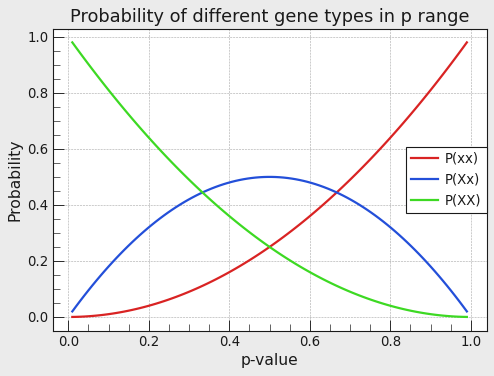

In [21]:
p = 0.5
def color_p(p):
    red = p**2
    mixed = 2*p*(1-p)
    black = 1 - red - mixed
    return red, mixed, black

p_lin = np.linspace(0.01, 0.99, 100)
red, mixed, black = color_p(p_lin)
plt.plot(p_lin, red, label = "P(xx)")
plt.plot(p_lin, mixed, label = "P(Xx)")
plt.plot(p_lin, black, label = "P(XX)")
plt.xlabel("p-value")
plt.ylabel("Probability")
plt.title("Probability of different gene types in p range")
plt.legend()
plt.savefig("./gene_prob_3a.pdf", facecolor = "white")

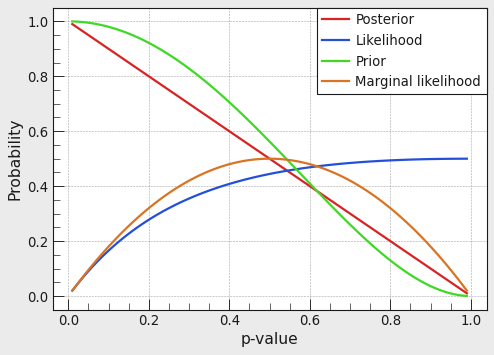

In [55]:
def p_xX(p):
    return 2*p*(1-p)

def p_xx(p):
    return p**2

def p_XX(p):
    return 1 - p_xx(p) - p_xX(p)

def prior(p):
    return (1 - p_xx(p))**2

def marginal_likelihood(p):
    return p_xX(p)
    
def likelihood(p):
    return (1/2*p_xX(p)*p_xX(p) + 2*1/2*p_xX(p)*p_XX(p))/(p_XX(p)*p_XX(p) + p_xX(p)*p_xX(p) + 2*p_xX(p)*p_XX(p))

def likelihood2(p):
    return (2 * p_xx(p)*p_xX(p)*1/2 + 2 *p_xx(p)*p_XX(p))/2 * p_xx(p)*p_xX(p) + 2 * p_xx(p)*p_XX(p)

def bayes(likelihood, prior, marginal_likelihood):
    return likelihood*prior/marginal_likelihood

p_lin = np.linspace(0.01, 0.99, 100)
p_values = bayes(likelihood(p_lin), prior(p_lin), marginal_likelihood(p_lin))
plt.plot(p_lin, p_values, label = "Posterior")
plt.plot(p_lin, likelihood(p_lin), label = "Likelihood")
plt.plot(p_lin, prior(p_lin), label = "Prior")
plt.plot(p_lin, marginal_likelihood(p_lin), label = "Marginal likelihood")
plt.xlabel("p-value")
plt.ylabel("Probability")
# plt.title("")
plt.legend()
plt.savefig("./bayes_3a.pdf", facecolor = "white")

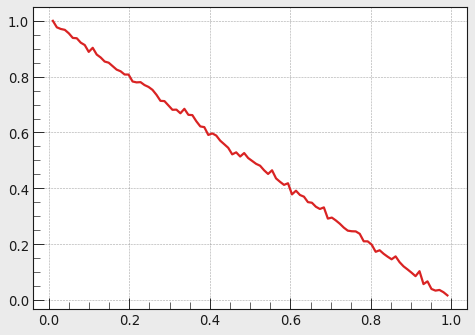

In [23]:

def child_maker(couple):
    parent1, parent2 = couple
    gen1 = np.random.choice(parent1)
    gen2 = np.random.choice(parent2)
    return gen1 + gen2

def couple_maker(p, N):
    first_parent = np.random.uniform(0,1,N)
    second_parent = np.random.uniform(0,1,N)
    gens1 = np.array([[0,0] for n in range(N)]) 
    gens2 = np.array([[0,0] for n in range(N)]) 
    gens1[first_parent < p_xx(p)] = [0,0]
    gens2[second_parent < p_xx(p)] = [0,0]
    gens1[np.logical_and(first_parent > p_xx(p), first_parent < p_xx(p) + p_xX(p))] = [0,1]
    gens2[np.logical_and(second_parent > p_xx(p), second_parent < p_xx(p) + p_xX(p))] = [0,1]
    gens1[first_parent > p_xx(p) + p_xX(p)] = [1,1]
    gens2[second_parent > p_xx(p) + p_xX(p)] = [1,1]
    couples = np.array(list(zip(list(gens1), list(gens2))))
    return couples


n = 10000
ratios = np.zeros_like(p_lin)
for idx, p in enumerate(p_lin):
    couples = couple_maker(p, n)
    children = np.array([child_maker(couple) for couple in couples])
    children_mask = children == 1
    couples_1 = couples[children_mask]
    bb_mask = np.sum([np.logical_and(a != [0,0], b != [0,0]) for a,b in couples_1])
    ratio = bb_mask/len(couples_1)
    ratios[idx] = ratio
    # ratios.append(ratio)

plt.plot(p_lin, ratios)
    

[0.001      0.01118367 0.02136735 0.03155102 0.04173469 0.05191837
 0.06210204 0.07228571 0.08246939 0.09265306 0.10283673 0.11302041
 0.12320408 0.13338776 0.14357143 0.1537551  0.16393878 0.17412245
 0.18430612 0.1944898  0.20467347 0.21485714 0.22504082 0.23522449
 0.24540816 0.25559184 0.26577551 0.27595918 0.28614286 0.29632653
 0.3065102  0.31669388 0.32687755 0.33706122 0.3472449  0.35742857
 0.36761224 0.37779592 0.38797959 0.39816327 0.40834694 0.41853061
 0.42871429 0.43889796 0.44908163 0.45926531 0.46944898 0.47963265
 0.48981633 0.5        0.51018367 0.52036735 0.53055102 0.54073469
 0.55091837 0.56110204 0.57128571 0.58146939 0.59165306 0.60183673
 0.61202041 0.62220408 0.63238776 0.64257143 0.6527551  0.66293878
 0.67312245 0.68330612 0.6934898  0.70367347 0.71385714 0.72404082
 0.73422449 0.74440816 0.75459184 0.76477551 0.77495918 0.78514286
 0.79532653 0.8055102  0.81569388 0.82587755 0.83606122 0.8462449
 0.85642857 0.86661224 0.87679592 0.88697959 0.89716327 0.90734

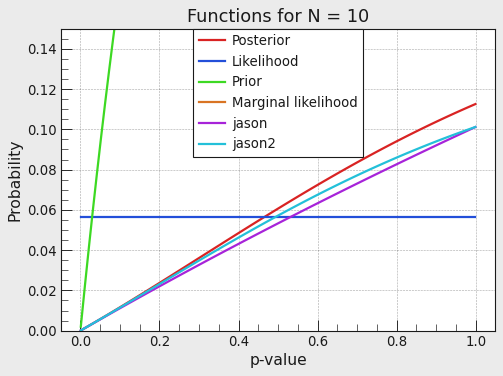

In [91]:
# P(xX | N(black haired children) ∩ parents with blackhair) = 
# 
#   
# P(N(black haired children) ∩ parents with blackhair | xX) P(xX) / P(N(black haired children) ∩ parents with blackhair)
# P(N(black haired children) ∩ parents with blackhair) = P(N(black haired children) | parents with blackhair) * p (parents with blackhair)
N = 10
p_lin = np.linspace(0.001, 0.999, 99)
print(p_lin)

# P(xX)
def prior_3b(N, p):
    return (p_XX(p)**2*0 + 2*p_xX(p)*p_XX(p)*1/2 + p_xX(p)*p_xX(p)*2/3)/(p_XX(p)**2 + 2*p_xX(p)*p_XX(p)  + p_xX(p)*p_xX(p)) #* (1 - p_xx(p))**2 * p_xX(p)

def mlh_3b(N, p):
    return ((p_XX(p)**2 + 2*p_XX(p)*p_xX(p)*(1/2 + 1/2*3/4**N) + p_xX(p)**2*(1/3 + 2/3*3/4**N))/(p_XX(p)**2 + 2*p_XX(p)*p_xX(p) + p_xX(p)**2)) #* (1 - p_xx(p))**2 * p_xX(p)

# def mlh_3b2(N,p):
#     return (p_XX(p)**2 + 2*p_XX(p)*p_xX(p)*(1/2 + 1/2*3/4) + p_xX(p)**2*(1/4 + 1/2*3/4))/(p_XX(p)**2 + 2*p_XX(p)*p_xX(p) + 3/4*p_xX(p)**2)

def lh_3b(N, p):    
    return np.array([(3/4)**N for i in p])

def jason_solu(N,p):
    return 2*p*(3/4)**N/(1+2*p*(3/4)**N)

def jason_solu2(N,p):
    return 2*p*(3/4)**N*(p+3)/(3+2*p*(3/4)**N*(p+3)+p**2)

# def test(p):
#     return p_XX(p)**2 + 2*p_XX(p)*p_xX(p) + p_xX(p)**2 + 2*p_xX(p)*p_xx(p) + p_xx(p)**2 + 2*p_xx(p) * p_XX(p)
# print(test(p_lin))
fig, ax = plt.subplots()
ax.plot(p_lin, bayes(lh_3b(N,p_lin), prior_3b(N, p_lin), mlh_3b(N,p_lin)), label = "Posterior")
ax.plot(p_lin, lh_3b(N, p_lin), label = "Likelihood")
ax.plot(p_lin, prior_3b(N, p_lin), label = "Prior")
ax.plot(p_lin, mlh_3b(N, p_lin), label = "Marginal likelihood")
ax.plot(p_lin, jason_solu(N, p_lin), label = "jason")
ax.plot(p_lin, jason_solu2(N, p_lin), label = "jason2")
ax.set(xlabel = "p-value", ylabel = "Probability", title = f"Functions for N = {N:d}")
ax.set_ylim(0, 0.15)
ax.legend()
plt.savefig("./bayes_3b_N10.pdf", facecolor = "white")


504.67408 462.0 541.0


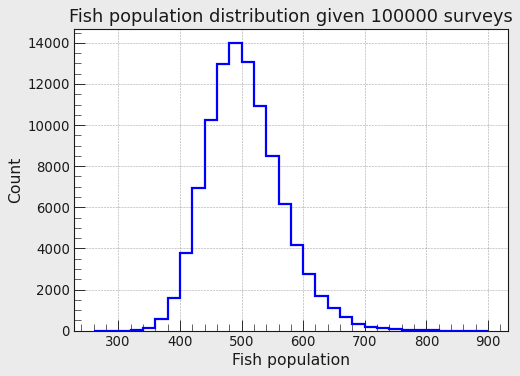

In [ ]:
def gen_lakearea():
    return np.random.normal(5000, 300)

def gen_fisharea():
    return np.random.normal(10, 1)
tries = 1000
fish_pop_array = np.zeros(tries)
for i in range(tries):
    lakearea = gen_lakearea()
    fisharea = gen_fisharea()
    fish_pop = np.floor(lakearea/fisharea)
    fish_pop_array[i] = fish_pop
print(np.mean(fish_pop_array), np.quantile(fish_pop_array, 0.25), np.quantile(fish_pop_array, 0.75))
plt.hist(fish_pop_array, bins = 32, range=(260, 900), color = "b", histtype="step", linewidth = 2)
plt.xlabel("Fish population")
plt.ylabel("Count")
plt.title("Fish population distribution given 100000 surveys")
plt.savefig("./fish_pop.pdf", facecolor = "white")

(array([  2.,   6.,  43., 129., 230., 272., 188.,  90.,  34.,   6.]),
 array([497.899 , 499.1795, 500.46  , 501.7405, 503.021 , 504.3015,
        505.582 , 506.8625, 508.143 , 509.4235, 510.704 ]),
 <BarContainer object of 10 artists>)

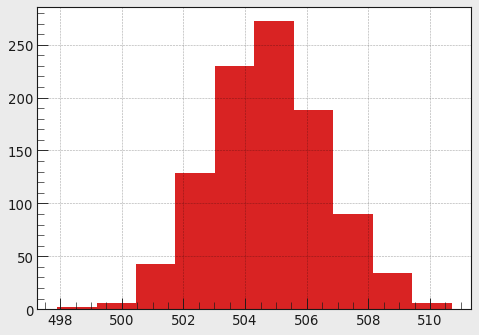

In [41]:
mean_fish_list = np.zeros(1000)
tries = 1000
for j in range(1000):
    fish_pop_array = np.zeros(tries)
    for i in range(tries):
        lakearea = gen_lakearea()
        fisharea = gen_fisharea()
        fish_pop = np.floor(lakearea/fisharea)
        fish_pop_array[i] = fish_pop
    mean = np.mean(fish_pop_array)
    mean_fish_list[j] = mean
    
plt.hist(mean_fish_list)